### Load Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Process data

In [ ]:
import os

label_map = {'Van': 0, 'Cyclist': 1, 'Pedestrian': 2, 'Car': 3}

def parse_line(line):
    parts = line.strip().split()
    label = parts[0]
    if label == '-1':
        return None
    category = parts[2]
    if category not in label_map:
        return None
    label_id = label_map[category]
    coordinates = ' '.join(parts[6:16])
    return f"{label_id} {coordinates}\n"

def process_file(input_file, output_folder):
    with open(input_file, 'r') as f:
        lines = f.readlines()

    current_frame = None
    current_lines = []

    for line in lines:
        frame_id = line.strip().split()[0]
        if frame_id != current_frame:
            if current_lines:
                output_file_path = os.path.join(output_folder, f"{current_frame.zfill(6)}.txt")
                with open(output_file_path, 'w') as output_file:
                    output_file.writelines(current_lines)
            current_frame = frame_id
            current_lines = []
        parsed_line = parse_line(line)
        if parsed_line:
            current_lines.append(parsed_line)

    # Write the last frame
    if current_lines:
        output_file_path = os.path.join(output_folder, f"{current_frame.zfill(6)}.txt")
        with open(output_file_path, 'w') as output_file:
            output_file.writelines(current_lines)

def process_folder(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith('.txt'):
            input_file = os.path.join(input_folder, filename)
            output_subfolder = os.path.join(output_folder, os.path.splitext(filename)[0])
            if not os.path.exists(output_subfolder):
                os.makedirs(output_subfolder)
            process_file(input_file, output_subfolder)

if __name__ == "__main__":
    input_folder = "/content/drive/MyDrive/training/label_02"
    output_folder = "/content/drive/MyDrive/training/label_out"
    process_folder(input_folder, output_folder)


### Check label

In [ ]:
!head /content/drive/MyDrive/training/label_out/0000/000004.txt

0 290.287584 146.641981 444.387179 269.473545 2.000000 1.823255 4.433886 -4.934786 1.601945 14.098646
1 767.158958 140.942948 961.992360 374.000000 1.739063 0.824591 1.785241 1.881359 1.534695 5.785600
2 1180.675035 151.025283 1241.000000 325.015204 1.714062 0.767881 0.972283 6.516488 1.497786 7.267796


### Join all the data

In [ ]:
import os
import shutil

def combine_folders(images_folder, labels_folder, combined_images_folder, combined_labels_folder):
    if not os.path.exists(combined_images_folder):
        os.makedirs(combined_images_folder)
    if not os.path.exists(combined_labels_folder):
        os.makedirs(combined_labels_folder)

    counter = 0
    for folder_name in sorted(os.listdir(images_folder)):
        images_subfolder = os.path.join(images_folder, folder_name)
        labels_subfolder = os.path.join(labels_folder, folder_name)

        if os.path.isdir(images_subfolder) and os.path.isdir(labels_subfolder):
            for image_file in sorted(os.listdir(images_subfolder)):
                image_path = os.path.join(images_subfolder, image_file)
                label_path = os.path.join(labels_subfolder, image_file.replace('.png', '.txt'))

                if os.path.isfile(image_path) and os.path.isfile(label_path):
                    combined_image_name = str(counter).zfill(6) + ".png"
                    combined_label_name = str(counter).zfill(6) + ".txt"

                    combined_image_path = os.path.join(combined_images_folder, combined_image_name)
                    combined_label_path = os.path.join(combined_labels_folder, combined_label_name)

                    shutil.copyfile(image_path, combined_image_path)
                    shutil.copyfile(label_path, combined_label_path)

                    counter += 1

    print("Combining folders completed.")

if __name__ == "__main__":
    images_folder = "/content/drive/MyDrive/training/image_02"
    labels_folder = "/content/drive/MyDrive/training/label_out"
    combined_images_folder = "/content/drive/MyDrive/training/out_image"
    combined_labels_folder = "/content/drive/MyDrive/training/out_label"

    combine_folders(images_folder, labels_folder, combined_images_folder, combined_labels_folder)


Combining folders completed.


### Visualize dataset

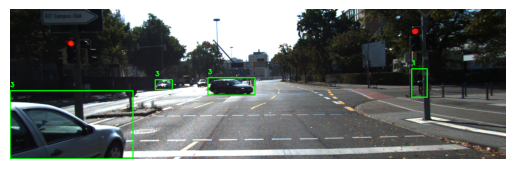

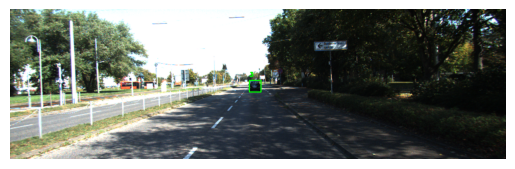

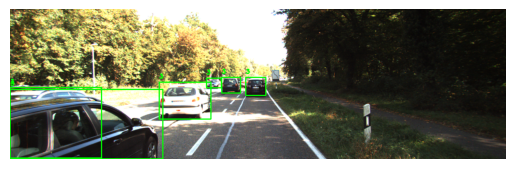

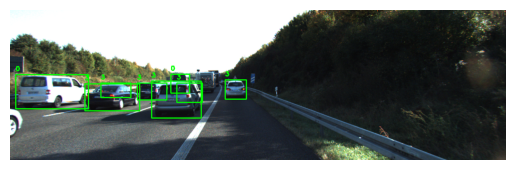

In [ ]:
import os
import cv2
import random
import matplotlib.pyplot as plt

def draw_bounding_boxes(image_folder, label_folder, num_images=4):
    image_files = os.listdir(image_folder)
    selected_images = random.sample(image_files, num_images)

    for image_file in selected_images:
        image_path = os.path.join(image_folder, image_file)
        label_path = os.path.join(label_folder, os.path.splitext(image_file)[0] + ".txt")

        # Read image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Read labels
        with open(label_path, 'r') as file:
            lines = file.readlines()

        # Draw bounding boxes
        for line in lines:
            elements = line.strip().split()
            if len(elements) >= 10:
                label = elements[0]
                x_min, y_min, x_max, y_max = map(float, elements[1:5])
                x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Display image with bounding boxes
        plt.imshow(image)
        plt.axis('off')
        plt.show()

# Replace 'image_folder' and 'label_folder' with your folder paths
image_folder = "/content/drive/MyDrive/training/out_image"
label_folder = "/content/drive/MyDrive/training/out_label"
draw_bounding_boxes(image_folder, label_folder)


### Label destribution

In [ ]:
import os
import matplotlib.pyplot as plt
from collections import Counter

def read_first_values_from_files(folder_path):
    first_values = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                for line in file:
                    first_value = line.split()[0]  # Assuming values are space-separated
                    first_values.append(first_value)
    return first_values

def plot_distribution(first_values):
    # Count the occurrences of each value
    value_counts = Counter(first_values)

    # Separate the keys and values for plotting
    keys = list(value_counts.keys())
    values = list(value_counts.values())

    # Create the bar graph
    plt.figure(figsize=(10, 5))
    plt.bar(keys, values, color='blue')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Distribution of First Values in Text Files')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def main(folder_path):
    first_values = read_first_values_from_files(folder_path)
    plot_distribution(first_values)

# Example usage:
folder_path = '/content/drive/MyDrive/training/out_label'  # Replace with the path to your folder
main(folder_path)



### Check label and image if have the same number of files

In [ ]:
import os
import numpy as np

def verify_labels_format(label_folder):
    # Check the format of the labels in the label folder
    for filename in os.listdir(label_folder):
        filepath = os.path.join(label_folder, filename)
        if os.path.isfile(filepath) and filename.endswith('.txt'):
            with open(filepath, 'r') as file:
                for line in file:
                    # Split the line and check if it contains numerical values
                    values = line.strip().split()
                    for value in values[1:]:
                        try:
                            float(value)
                        except ValueError:
                            print(f"Error: Invalid value '{value}' in file '{filename}'")
                            return False
    return True

def preprocess_labels(label_folder):
    # Preprocess the labels if needed
    # In this example, we assume no preprocessing is needed
    pass

def verify_input_data(image_folder, label_folder):
    # Verify the input data (both images and labels)
    for filename in os.listdir(image_folder):
        image_path = os.path.join(image_folder, filename)
        label_path = os.path.join(label_folder, filename.replace('.png', '.txt'))
        if not os.path.isfile(label_path):
            print(f"Error: Label file not found for image '{filename}'")
            return False
    return True

# Main function to verify all points
def verify_data(image_folder, label_folder):
    if not verify_labels_format(label_folder):
        return False
    preprocess_labels(label_folder)
    if not verify_input_data(image_folder, label_folder):
        return False
    print("Data verification successful!")
    return True

# Example usage:
image_folder = "/content/drive/MyDrive/training/out_image"
label_folder = "/content/drive/MyDrive/training/out_label"
verify_data(image_folder, label_folder)


Data verification successful!


True